In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib

from IPython import display

2.4.1


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
use_microfrontend = True
#dataset = 'mini-speech' # 'full-speech'

In [28]:

data_dir = pathlib.Path('C:/Users/hpate108/Downloads/project1/my_dataset') #os.path.join(os.getenv("HOME"),
 
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']

print('Commands:', commands)

Commands: ['credit' 'silence' 'stop' 'unknown']


In [29]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
     len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 2411
Number of examples per label: 23
Example file tensor: tf.Tensor(b'C:\\Users\\hpate108\\Downloads\\project1\\my_dataset\\unknown\\no (205).wav', shape=(), dtype=string)


In [31]:

num_train_files = 1800
num_val_files = 311
num_test_files = num_samples - num_train_files - num_val_files
train_files = filenames[:num_train_files]
val_files = filenames[num_train_files: num_train_files + num_val_files]
test_files = filenames[-num_test_files:]


print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 1800
Validation set size 311
Test set size 300


In [32]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [33]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [34]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [35]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=40,
                                    window_size=40, window_step=20)
  return spectrogram


In [36]:
tf.shape('no/0ab3b47d_nohash_0.wav')

<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>

Function to convert each waveform in a set into a spectrogram, then convert those
back into a dataset using `from_tensor_slices`.  (We should be able to use 
`wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
   

In [37]:
def wavds2specds(waveform_ds):
  spec_grams = np.zeros((0, 49, 40, 1))
  labels = []
  for wav, label in waveform_ds:
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams = np.concatenate((spec_grams, spectrogram))
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == commands)
    labels.append(new_label_id) # for numeric labels
    # labels.append(new_label) # for string labels
  return tf.data.Dataset.from_tensor_slices((spec_grams, labels))  

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
print(waveform_ds)
train_ds = wavds2specds(waveform_ds)

<ParallelMapDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>


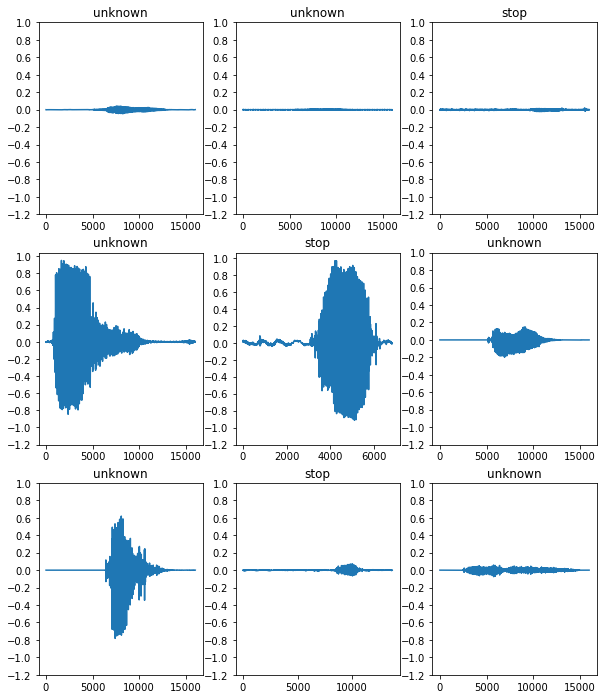

In [39]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [40]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: unknown
Waveform shape: (16000,)
Spectrogram shape: (49, 40)
Audio playback


<ipython-input-41-e1cd5567c8a2>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


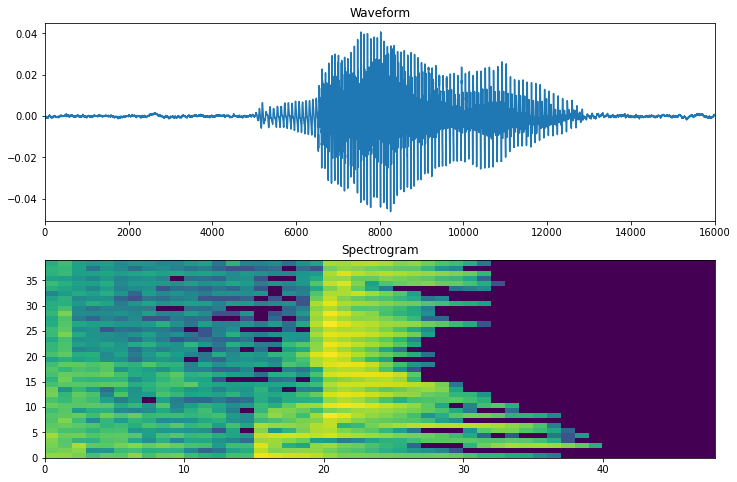

In [41]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

<ipython-input-41-e1cd5567c8a2>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


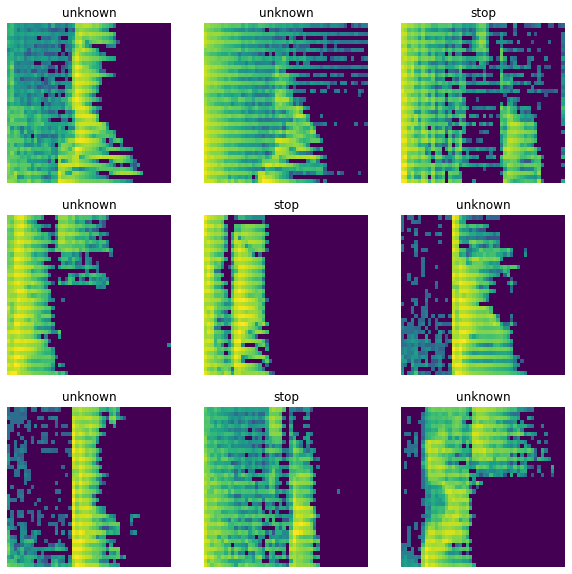

In [42]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [43]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [44]:
## training set is already builst
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [45]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [46]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (49, 40, 1)
ranges from 0.0 to 709.0


In [47]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [48]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(commands)


Input shape: (49, 40, 1)


In [49]:
print('Input shape:', input_shape)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.DepthwiseConv2D (3,input_shape=input_shape,padding='same'), 
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
], name="simple_cnn")

model.summary()

Input shape: (49, 40, 1)
Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d (DepthwiseC (None, 49, 40, 1)         10        
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 38, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 19, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 19, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 4, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (N

In [50]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [51]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/10
29/29 [==============================] - 2s 60ms/step - loss: 1.2940 - accuracy: 0.4948 - val_loss: 0.6620 - val_accuracy: 0.7460
Epoch 2/10
29/29 [==============================] - 2s 53ms/step - loss: 0.5900 - accuracy: 0.7732 - val_loss: 0.3963 - val_accuracy: 0.8521
Epoch 3/10
29/29 [==============================] - 2s 54ms/step - loss: 0.3954 - accuracy: 0.8475 - val_loss: 0.2914 - val_accuracy: 0.8842
Epoch 4/10
29/29 [==============================] - 2s 54ms/step - loss: 0.3262 - accuracy: 0.8685 - val_loss: 0.2480 - val_accuracy: 0.8971
Epoch 5/10
29/29 [==============================] - 2s 55ms/step - loss: 0.2873 - accuracy: 0.8851 - val_loss: 0.2292 - val_accuracy: 0.9068
Epoch 6/10
29/29 [==============================] - 2s 56ms/step - loss: 0.1940 - accuracy: 0.9295 - val_loss: 0.2123 - val_accuracy: 0.9068
Epoch 7/10
29/29 [==============================] - 2s 58ms/step - loss: 0.2153 - accuracy: 0.9025 - val_loss: 0.1824 - val_accuracy: 0.9421
Epoch 8/10
29

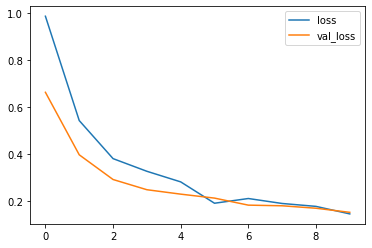

In [52]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [53]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [54]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 94%


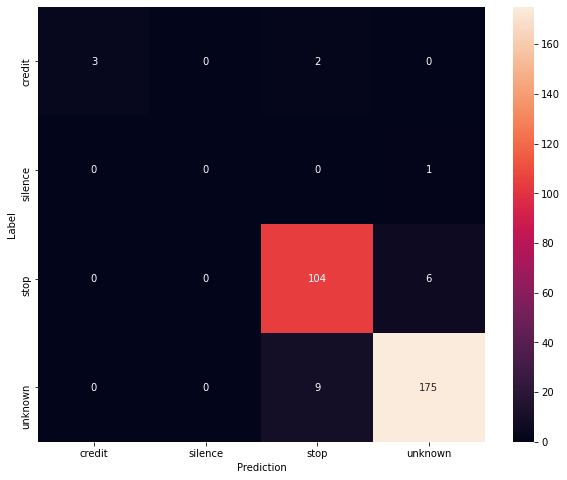

In [55]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Quantize and Convert to TFLite

In [56]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [57]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [58]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [59]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hpate108\AppData\Local\Temp\2\tmp38k7gwb2\assets


In [60]:
fname = 'mymodel.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 54296 / 54296 bytes to tflite file


In [61]:
!cd

C:\Users\hpate108\Downloads


In [ ]:
# then use xxd to convert the tflite file => c file